In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time
from mpl_toolkits.mplot3d import Axes3D 
import scipy
import sys

In [2]:
import gymnasium
from gymnasium import spaces

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp 
from deap import base
from deap import creator
from deap import tools
import random
import seaborn as sns

In [4]:
sys.path.append('../../../ocean_intella/ocean_intella/pipelay_profile_optimization/')

In [5]:
import elitism

In [6]:
x0, y0 = 28, 28

### Finite Element Model

In [7]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
#     print(params)
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [8]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [9]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [10]:
# @autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
# autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [11]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [12]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [13]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [14]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

# @autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

# autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
#                        lambda: print('err: gradient undefined'),
#                        lambda: print('err: gradient not implemented'))

In [15]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [16]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X) 
    plt.show()

### Genetic Modelling

In [17]:
# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 2000
HALL_OF_FAME_SIZE = 30

In [18]:
PENALTY_VALUE = 1000.0 

In [19]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [20]:
toolbox = base.Toolbox()

In [21]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [22]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [23]:
# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [24]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.zeroOrOne, 
                 x0*y0+4)

In [25]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individualCreator)

In [26]:
# convert a binary list to decimal
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

In [27]:
class Prev:
    def __init__(self):
        self.prev = 100

In [28]:
T=Prev()

In [29]:
# fitness calculation
def staticFEM(individual):
    
    args = get_args(*mbb_beam(rd=-1))
    
    x = np.array([t if t==1 else 1e-4 for t in individual[:-4]]) 
    
    
    try:
        if np.sum(x)/(x0*y0) > 0.5:
            tmp, const = fast_stopt(args, x)
            T.prev=tmp
            if const>(55+binatodeci(individual[-4:]))/100:
                return PENALTY_VALUE, 
        else:
            return T.prev,
    except:
        return PENALTY_VALUE, 
    
    
    return tmp,  # return a tuple

In [30]:
toolbox.register("evaluate", staticFEM)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/(x0*y0+4))

In [31]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()
    
    x = np.array(best[:-4]).astype(np.float64).reshape(x0,y0)
    
    args = get_args(*mbb_beam(rd=-1))
    print(fast_stopt(args, x))
    
    draw(x)
    

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
  
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()    
    return x

gen	nevals	min	avg    
0  	300   	100	3845.81
1  	250   	98.1005	837.421
2  	244   	94.1888	317.1  
3  	233   	90.0268	478.344
4  	236   	87.2006	149.739
5  	239   	79.2249	577.534
6  	240   	76.1653	334.388
7  	247   	74.3453	328.616
8  	241   	74.0583	122.298
9  	254   	73.2667	105.207
10 	245   	70.0644	108.344
11 	233   	68.6773	120.211
12 	244   	68.6773	124.42 
13 	246   	66.9468	106.083
14 	256   	64.7752	105.803
15 	244   	63.6245	83.1807
16 	251   	60.8671	99.4599
17 	244   	59.6026	91.9051
18 	248   	59.1205	74.9035
19 	230   	57.4594	89.1338
20 	249   	57.4267	90.9483
21 	236   	55.8435	118.002
22 	243   	55.319 	145.076
23 	251   	52.2014	172.485
24 	245   	52.2014	118.186
25 	236   	52.2014	148.768
26 	248   	52.2014	185.822
27 	249   	51.4503	163.273
28 	243   	51.4503	146.952
29 	250   	51.4503	174.575
30 	245   	51.4503	208.793
31 	254   	51.0401	186.354
32 	253   	50.7853	170.206
33 	253   	50.084 	179.121
34 	244   	50.084 	219.901
35 	261   	50.084 	172.107
36 	247  

303	248   	25.1153	187.683
304	250   	25.098 	174.685
305	237   	25.0973	184.426
306	252   	25.0862	171.442
307	247   	25.0761	194.185
308	252   	25.0162	164.931
309	253   	24.9973	177.888
310	242   	24.9973	158.379
311	243   	24.9693	129.112
312	243   	24.9693	155.088
313	241   	24.9034	181.076
314	252   	24.9034	155.061
315	251   	24.9034	168.046
316	241   	24.9034	181.025
317	260   	24.8634	190.781
318	240   	24.8598	168.047
319	244   	24.7964	145.26 
320	237   	24.7964	154.991
321	244   	24.7964	161.47 
322	247   	24.7919	161.46 
323	240   	24.7919	167.943
324	244   	24.7693	171.181
325	251   	24.7693	141.908
326	248   	24.7642	148.396
327	246   	24.7642	119.123
328	245   	24.7642	141.856
329	242   	24.7642	135.342
330	236   	24.7642	154.842
331	256   	24.7397	109.328
332	249   	24.7397	138.567
333	239   	24.7156	112.558
334	246   	24.7066	132.103
335	236   	24.7066	135.304
336	249   	24.7066	151.552
337	247   	24.6886	125.559
338	250   	24.6886	125.563
339	239   	24.6863	128.803
3

607	255   	22.332 	143.007
608	244   	22.332 	123.444
609	227   	22.332 	110.398
610	257   	22.332 	126.683
611	240   	22.332 	116.869
612	230   	22.332 	87.5524
613	237   	22.332 	94.0516
614	247   	22.332 	120.122
615	246   	22.332 	107.089
616	246   	22.332 	84.2659
617	248   	22.3231	71.2404
618	244   	22.3231	74.4839
619	253   	22.3058	67.9677
620	234   	22.3058	74.4929
621	245   	22.3058	71.2241
622	246   	22.2646	100.55 
623	249   	22.2603	129.915
624	240   	22.2603	123.362
625	247   	22.2603	110.326
626	243   	22.2523	129.871
627	246   	22.2523	123.353
628	245   	22.2523	129.869
629	254   	22.2523	146.148
630	248   	22.2523	103.805
631	245   	22.2441	97.2385
632	248   	22.2441	90.7141
633	246   	22.2441	97.2247
634	247   	22.2441	113.522
635	240   	22.2441	77.6713
636	251   	22.2441	116.776
637	240   	22.2409	107.035
638	246   	22.2409	103.768
639	253   	22.2409	139.586
640	249   	22.2409	110.292
641	242   	22.2392	168.918
642	251   	22.2392	172.205
643	251   	22.227 	126.55 
6

911	234   	21.8599	126.216
912	248   	21.8599	145.777
913	242   	21.8599	142.532
914	259   	21.8599	188.201
915	249   	21.8599	181.655
916	249   	21.8599	175.128
917	245   	21.8543	129.49 
918	238   	21.8485	142.519
919	240   	21.8485	129.468
920	238   	21.8485	135.988
921	246   	21.8485	100.124
922	223   	21.8485	158.806
923	244   	21.8485	109.904
924	249   	21.8485	126.236
925	240   	21.8485	113.156
926	251   	21.8485	139.244
927	251   	21.8435	122.947
928	244   	21.8435	106.643
929	246   	21.8435	83.8313
930	232   	21.8435	93.5926
931	236   	21.8435	80.5598
932	229   	21.8435	80.5455
933	241   	21.8435	80.5457
934	244   	21.8435	93.5877
935	237   	21.8435	109.887
936	253   	21.8435	103.375
937	248   	21.8435	100.107
938	235   	21.8435	116.419
939	255   	21.8421	119.674
940	243   	21.8421	113.149
941	241   	21.8421	132.711
942	251   	21.8421	132.712
943	250   	21.8408	142.493
944	251   	21.8408	142.497
945	248   	21.8408	116.412
946	252   	21.8408	122.939
947	244   	21.8408	96.8477
9

1207	252   	21.8073	47.8984
1208	262   	21.8073	51.1633
1209	254   	21.8073	31.5924
1210	242   	21.8073	41.3741
1211	241   	21.8073	34.8532
1212	250   	21.8073	44.6395
1213	247   	21.8073	28.3343
1214	252   	21.8073	34.8577
1215	241   	21.8073	38.1149
1216	241   	21.8073	54.4159
1217	245   	21.8073	38.1167
1218	230   	21.8073	25.0707
1219	248   	21.8073	34.8552
1220	250   	21.8073	31.6278
1221	242   	21.8073	28.3493
1222	232   	21.8073	38.1162
1223	244   	21.8073	38.1176
1224	248   	21.8073	34.8919
1225	247   	21.8073	51.1554
1226	252   	21.8073	34.8849
1227	243   	21.8073	31.5952
1228	241   	21.8073	41.3752
1229	241   	21.8073	38.1152
1230	254   	21.8073	34.8531
1231	235   	21.8073	44.6362
1232	245   	21.8073	28.3323
1233	247   	21.8073	47.8981
1234	250   	21.8073	44.6381
1235	237   	21.8073	44.6368
1236	247   	21.8073	51.1606
1237	244   	21.8073	34.8562
1238	248   	21.8061	34.8549
1239	256   	21.8061	51.1559
1240	242   	21.8061	60.9427
1241	256   	21.8061	64.2031
1242	237   	21.8061	

1500	253   	21.734 	100.015
1501	250   	21.734 	113.069
1502	256   	21.734 	100.095
1503	255   	21.734 	100.028
1504	241   	21.734 	77.1839
1505	244   	21.734 	57.645 
1506	252   	21.734 	64.1373
1507	248   	21.734 	38.0473
1508	249   	21.734 	44.5688
1509	251   	21.734 	34.7941
1510	238   	21.734 	31.5221
1511	242   	21.734 	31.525 
1512	245   	21.734 	34.8253
1513	242   	21.734 	34.7818
1514	238   	21.734 	38.0856
1515	244   	21.734 	51.0852
1516	250   	21.734 	38.0881
1517	253   	21.7337	57.6502
1518	247   	21.7337	67.3968
1519	246   	21.7337	41.3215
1520	249   	21.7319	54.3471
1521	247   	21.7319	51.0867
1522	248   	21.7319	44.5645
1523	248   	21.7319	47.8352
1524	248   	21.7319	80.435 
1525	234   	21.7319	57.6306
1526	245   	21.7319	86.957 
1527	253   	21.7319	106.526
1528	238   	21.7319	90.2178
1529	247   	21.7319	80.4526
1530	248   	21.7319	93.5188
1531	245   	21.731 	86.9591
1532	241   	21.731 	73.9254
1533	241   	21.731 	80.4344
1534	241   	21.731 	93.4763
1535	240   	21.731 	

1793	240   	21.7306	34.7778
1794	257   	21.7306	38.0368
1795	238   	21.7306	51.0836
1796	254   	21.7306	51.1129
1797	250   	21.7306	38.0532
1798	249   	21.7306	47.8216
1799	243   	21.7306	38.0424
1800	246   	21.7306	31.5162
1801	243   	21.7306	41.3088
1802	245   	21.7306	25.0078
1803	255   	21.7306	38.0476
1804	243   	21.7306	41.3011
1805	246   	21.7306	38.0541
1806	253   	21.7306	34.7802
1807	248   	21.7306	51.0834
1808	252   	21.7306	47.821 
1809	251   	21.7306	31.5328
1810	239   	21.7306	34.7886
1811	253   	21.7306	34.7829
1812	246   	21.7306	44.5609
1813	251   	21.7306	44.6214
1814	242   	21.7306	31.556 
1815	243   	21.7306	24.9953
1816	245   	21.7306	34.7864
1817	242   	21.7306	34.7773
1818	250   	21.7306	38.0436
1819	247   	21.7306	34.7797
1820	248   	21.7306	25.0093
1821	244   	21.7306	31.523 
1822	243   	21.7306	41.301 
1823	252   	21.7306	31.519 
1824	241   	21.7306	44.5631
1825	244   	21.7306	28.2563
1826	250   	21.7306	38.0381
1827	255   	21.7306	31.5314
1828	246   	21.7306	

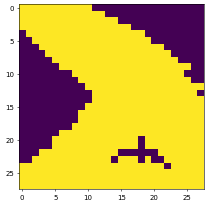

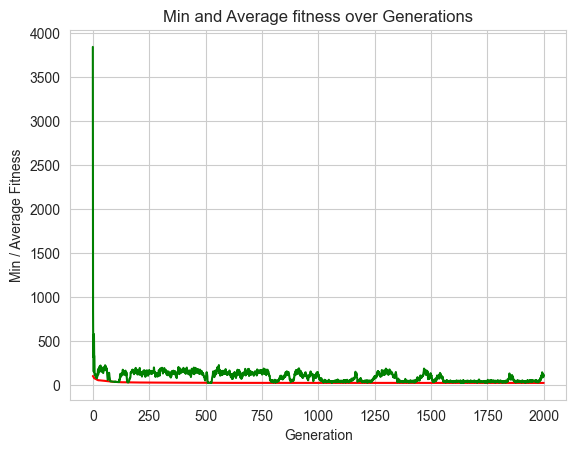

In [32]:
start = time.time()
top_ = main()
end = time.time() 

### RL model

In [33]:
class Model:
    def __init__(self, x):
        self.flag_ = True
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1

In [34]:
# def draw(X):  
#     plt.figure(dpi=50) 
#     print('\nFinal Cantilever beam design:')
#     plt.imshow(X) 
#     plt.show() 

In [35]:
class CantileverEnv(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self,x1,y1):
        super().__init__()
        self.x0=x1
        self.y0=y1
        
        DIM =  self.x0 * self.y0
        N_DISCRETE_ACTIONS = self.x0 * self.y0
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = np.zeros(( self.x0, self.y0))
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        self.ext_reward=0

        
    def step(self, action):
        
        
        self.M.action_space_(action, self.x)        
        self.step_+=1
               
        done=False
                  
        if self.step_ >  self.x0 * self.y0:
            done=True            
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
        
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.ext_reward, done, False, dict()

    def reset(self, seed=0):
                   
        self.x = np.zeros((self.x0, self.y0))

        self.reward=0
        self.needs_reset = False
        self.step_=0
        self.ext_reward=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        pass   

    def close(self):
        pass

In [36]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            
            
            
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
#             print(y)
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                
                mean_reward = np.mean(y[-100:])
                
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [37]:
def reconstruct_3d_structure(xy_plane, yz_plane, xz_plane):
    """
    Reconstructs a 3D structure from three 2D projections using extrusion and intersection.

    Parameters:
        xy_plane (ndarray): 2D binary array (X by Y) projection in XY plane.
        yz_plane (ndarray): 2D binary array (Y by Z) projection in YZ plane.
        xz_plane (ndarray): 2D binary array (X by Z) projection in XZ plane.

    Returns:
        volume (ndarray): 3D binary array (X by Y by Z) representing the reconstructed structure.
    """
    x_dim, y_dim = xy_plane.shape
    y_dim2, z_dim = yz_plane.shape
    x_dim2, z_dim2 = xz_plane.shape

    assert x_dim == x_dim2, "X dimensions mismatch between XY and XZ planes."
    assert y_dim == y_dim2, "Y dimensions mismatch between XY and YZ planes."
    assert z_dim == z_dim2, "Z dimensions mismatch between YZ and XZ planes."

    # Extrude XY along Z
    xy_extruded = np.repeat(xy_plane[:, :, np.newaxis], z_dim, axis=2)

    # Extrude YZ along X
    yz_extruded = np.repeat(yz_plane[np.newaxis, :, :], x_dim, axis=0)

    # Extrude XZ along Y
    xz_extruded = np.repeat(xz_plane[:, np.newaxis, :], y_dim, axis=1)

    # Intersect all three extrusions
    volume = xy_extruded & yz_extruded & xz_extruded

    return volume.astype(np.uint8)  # or bool, depending on your needs

In [38]:
def deconstruct(grid, topology, location):
    gr = grid.copy()
    row_offset = (location // 4) * x0//4
    col_offset = (location % 4) * x0//4
    gr[row_offset:row_offset+x0//4, col_offset:col_offset+x0//4] = topology
    return gr

In [39]:
def count_islands_dfs(grid):
    """
    Calculates the number of islands in a 2D binary grid using Depth First Search (DFS).

    An island is formed by connected 1's (horizontally/vertically adjacent).
    
    Args:
        grid (list of lists): A 2D matrix with values 0 or 1.

    Returns:
        int: The total number of islands found.
    """
#     if not grid or not grid[0]:
#         return 0
    
    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    island_count = 0

    def dfs(r, c):
        """Helper function to traverse and mark a single island as visited."""
        # Check boundary conditions and if the cell has already been visited or is water (0)
        if r < 0 or r >= rows or c < 0 or c >= cols or grid[r][c] == 0 or (r, c) in visited:
            return
        
        visited.add((r, c))
        
        # Recursively visit all adjacent cells (up, down, left, right)
        dfs(r + 1, c) # Down
        dfs(r - 1, c) # Up
        dfs(r, c + 1) # Right
        dfs(r, c - 1) # Left

    # Iterate through every cell in the grid
    for r in range(rows):
        for c in range(cols):
            # If we find land (1) that hasn't been visited yet, 
            # it means we've found the start of a new island.
            if grid[r][c] == 1 and (r, c) not in visited:
                island_count += 1
                # Start DFS from this point to mark all parts of this island
                dfs(r, c)
                
    return island_count

In [40]:
def calculate_smoothness_metric(binary_matrix):
    """
    Calculates a smoothness metric for a 2D binary matrix.
    Lower values indicate greater smoothness. A value of 0 means 
    the image is perfectly uniform or has only linear transitions.

    The metric is the sum of differences between a pixel and its
    right and bottom neighbors, effectively counting vertical and
    horizontal edges.

    Args:
        binary_matrix (list of lists or numpy array): A 2D matrix 
                                                     with values 0 or 1.

    Returns:
        int: The total count of horizontal and vertical transitions.
    """
    # Convert to a numpy array for efficient processing
    matrix = np.array(binary_matrix, dtype=int)
    h, w = matrix.shape
    
    # Calculate absolute differences for horizontal transitions
    # We slice the matrix to compare each element with its right neighbor
    horizontal_diffs = np.abs(matrix[:, :w-1] - matrix[:, 1:])
    
    # Calculate absolute differences for vertical transitions
    # We slice the matrix to compare each element with its bottom neighbor
    vertical_diffs = np.abs(matrix[:h-1, :] - matrix[1:, :])
    
    # The sum of these differences gives the total number of transitions (edges)
    total_transitions = np.sum(horizontal_diffs) + np.sum(vertical_diffs)
    
    return int(total_transitions)

In [41]:
class CrossRewardEnv(gymnasium.Env):
    def __init__(self):
        super().__init__()
        self.env0 = CantileverEnv(x0//4,y0//4)
        self.env1 = CantileverEnv(x0//4,y0//4)
        self.env2 = CantileverEnv(x0//4,y0//4)
        self.env3 = CantileverEnv(x0//4,y0//4)
        self.env4 = CantileverEnv(x0//4,y0//4)
        self.env5 = CantileverEnv(x0//4,y0//4)
        self.env6 = CantileverEnv(x0//4,y0//4)
        self.env7 = CantileverEnv(x0//4,y0//4)
        self.env8 = CantileverEnv(x0//4,y0//4)
        self.env9 = CantileverEnv(x0//4,y0//4)
        self.env10 = CantileverEnv(x0//4,y0//4)
        self.env11 = CantileverEnv(x0//4,y0//4)
        self.env12 = CantileverEnv(x0//4,y0//4)
        self.env13 = CantileverEnv(x0//4,y0//4)
        self.env14 = CantileverEnv(x0//4,y0//4)
        self.env15 = CantileverEnv(x0//4,y0//4)

        self.observation_space = spaces.Dict({
            'plane0': self.env0.observation_space,
            'plane1': self.env1.observation_space,
            'plane2': self.env2.observation_space,
            'plane3': self.env3.observation_space,
            'plane4': self.env4.observation_space,
            'plane5': self.env5.observation_space,
            'plane6': self.env6.observation_space,
            'plane7': self.env7.observation_space,
            'plane8': self.env8.observation_space,
            'plane9': self.env9.observation_space,
            'plane10': self.env10.observation_space,
            'plane11': self.env11.observation_space,
            'plane12': self.env12.observation_space,
            'plane13': self.env13.observation_space,
            'plane14': self.env14.observation_space,
            'plane15': self.env15.observation_space,
        })

        self.action_space = spaces.MultiDiscrete([x0*y0//16 for i in range(16)])
        self.step1_=0
        self.grid = top_.copy()
        
    def reset(self,seed=0):
        obs0, info0 = self.env0.reset()
        obs1, info1 = self.env1.reset()
        obs2, info2 = self.env2.reset()
        obs3, info3 = self.env3.reset()
        obs4, info4 = self.env4.reset()
        obs5, info5 = self.env5.reset()
        obs6, info6 = self.env6.reset()
        obs7, info7 = self.env7.reset()
        obs8, info8 = self.env8.reset()
        obs9, info9 = self.env9.reset()
        obs10, info10 = self.env10.reset()
        obs11, info11 = self.env11.reset()
        obs12, info12 = self.env12.reset()
        obs13, info13 = self.env13.reset()
        obs14, info14 = self.env14.reset()
        obs15, info15 = self.env15.reset()
        self.step1_=0
        self.grid = top_.copy()
        return {
            'plane0': obs0,
            'plane1': obs1,
            'plane2': obs2,
            'plane3': obs3,
            'plane4': obs4,
            'plane5': obs5,
            'plane6': obs6,
            'plane7': obs7,
            'plane8': obs8,
            'plane9': obs9,
            'plane10': obs10,
            'plane11': obs11,
            'plane12': obs12,
            'plane13': obs13,
            'plane14': obs14,
            'plane15': obs15,
        }, {
            'plane0':info0,
            'plane1':info1,
            'plane2': info2,
            'plane3': info3,
            'plane4': info4,
            'plane5': info5,
            'plane6': info6,
            'plane7': info7,
            'plane8': info8,
            'plane9': info9,
            'plane10': info10,
            'plane11': info11,
            'plane12': info12,
            'plane13': info13,
            'plane14': info14,
            'plane15': info15,
        }

    def step(self, action):
        a0 = action[0]
        a1 = action[1]
        a2 = action[2]
        a3 = action[3]
        a4 = action[4]
        a5 = action[5]
        a6 = action[6]
        a7 = action[7]
        a8 = action[8]
        a9 = action[9]
        a10 = action[10]
        a11 = action[11]
        a12 = action[12]
        a13 = action[13]
        a14 = action[14]
        a15 = action[15]
        
        
        obs0, r0, done0,_, info0 = self.env0.step(a0)
        obs1, r1, done1,_, info1 = self.env1.step(a1)
        obs2, r2, done2,_, info2 = self.env2.step(a2)
        obs3, r3, done3,_, info3 = self.env3.step(a3)
        obs4, r4, done4,_, info4 = self.env4.step(a4)
        obs5, r5, done5,_, info5 = self.env5.step(a5)
        obs6, r6, done6,_, info6 = self.env6.step(a6)
        obs7, r7, done7,_, info7 = self.env7.step(a7)
        obs8, r8, done8,_, info8 = self.env8.step(a8)
        obs9, r9, done9,_, info9 = self.env9.step(a9)
        obs10, r10, done10,_, info10 = self.env10.step(a10)
        obs11, r11, done11,_, info11 = self.env11.step(a11)
        obs12, r12, done12,_, info12 = self.env12.step(a12)
        obs13, r13, done13,_, info13 = self.env13.step(a13)
        obs14, r14, done14,_, info14 = self.env14.step(a14)
        obs15, r15, done15,_, info15 = self.env15.step(a15)
       
        OBS=[obs0,obs1,obs2,obs3,obs4,obs5,obs6,obs7,obs8,obs9,obs10,obs11,obs12,obs13,obs14,obs15]    
        REW = []
        for i in range(len(OBS)):
            gr = deconstruct(self.grid, OBS[i].reshape(x0//4,y0//4), i)
            constI=np.sum(gr)/(x0*y0)
         
            if constI>0.69:
                self.args = get_args(*mbb_beam(rd=-1))
                self.tmp, self.const = fast_stopt(self.args, gr.astype(float))
                reward = 1/self.tmp+1/calculate_smoothness_metric(gr.reshape(x0, y0))
                if count_islands_dfs(gr)==1:
                    reward*=10
            else:
                reward=0
            REW.append(reward)
        self.step1_+=1
         

        
        done = (done0 or done1 or done2 or done3 or done4 or done5 or done6 or
        done7 or done8 or done9 or done10 or done11 or done12 or done13 or
        done14 or done15)

       
        return {
             'plane0': obs0,
            'plane1': obs1,
            'plane2': obs2,
            'plane3': obs3,
            'plane4': obs4,
            'plane5': obs5,
            'plane6': obs6,
            'plane7': obs7,
            'plane8': obs8,
            'plane9': obs9,
            'plane10': obs10,
            'plane11': obs11,
            'plane12': obs12,
            'plane13': obs13,
            'plane14': obs14,
            'plane15': obs15,
        }, np.mean(REW), done, False, {
            'plane0':info0,
            'plane1':info1,
            'plane2': info2,
            'plane3': info3,
            'plane4': info4,
            'plane5': info5,
            'plane6': info6,
            'plane7': info7,
            'plane8': info8,
            'plane9': info9,
            'plane10': info10,
            'plane11': info11,
            'plane12': info12,
            'plane13': info13,
            'plane14': info14,
            'plane15': info15,
        }

    def render(self, mode='human'):    
        pass

    def close(self):
        self.env0.close()
        self.env1.close()
        self.env2.close()
        self.env3.close()
        self.env4.close()
        self.env5.close()
        self.env6.close()
        self.env7.close()
        self.env8.close()
        self.env9.close()
        self.env10.close()
        self.env11.close()
        self.env12.close()
        self.env13.close()
        self.env14.close()
        self.env15.close()

### Training 

In [42]:
ts = 1e6

In [43]:
# Create log dir
log_dir = "/tmp/gym7_v3agfsof/"
os.makedirs(log_dir, exist_ok=True)

In [44]:
callback = SaveOnBestTrainingRewardCallback(check_freq=50_000, log_dir=log_dir)

In [45]:
env=CrossRewardEnv()
check_env(env)
env  = Monitor(env, log_dir)

In [46]:
start = time.time()
model = PPO("MultiInputPolicy", env).learn(total_timesteps=ts, callback=callback)
end = time.time()  

Num timesteps: 50000
Best mean reward: -inf - Last mean reward per episode: 1.04
Saving new best model to /tmp/gym7_v3agfsof/best_model.zip
Num timesteps: 100000
Best mean reward: 1.04 - Last mean reward per episode: 1.04
Saving new best model to /tmp/gym7_v3agfsof/best_model.zip
Num timesteps: 150000
Best mean reward: 1.04 - Last mean reward per episode: 1.04
Num timesteps: 200000
Best mean reward: 1.04 - Last mean reward per episode: 1.05
Saving new best model to /tmp/gym7_v3agfsof/best_model.zip
Num timesteps: 250000
Best mean reward: 1.05 - Last mean reward per episode: 1.06
Saving new best model to /tmp/gym7_v3agfsof/best_model.zip
Num timesteps: 300000
Best mean reward: 1.06 - Last mean reward per episode: 1.39
Saving new best model to /tmp/gym7_v3agfsof/best_model.zip
Num timesteps: 350000
Best mean reward: 1.39 - Last mean reward per episode: 4.04
Saving new best model to /tmp/gym7_v3agfsof/best_model.zip
Num timesteps: 400000
Best mean reward: 4.04 - Last mean reward per episo

In [47]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 458.87478465239207 min


### Inference

In [48]:
def construct(OBS):
    grid = np.zeros((x0, y0), dtype=int)
    for i in range(len(OBS)):
        row_offset = (i // 4) * x0//4
        col_offset = (i % 4) * x0//4
        grid[row_offset:row_offset+x0//4, col_offset:col_offset+x0//4] = OBS[i]
    return grid 

In [49]:
obs = env.reset()

In [50]:
obs = obs[0]

In [51]:
i=0
ans=[]
while i < 1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(action)
    ans.append(obs)
    if dones:
        break
    i+=1

In [52]:
OBS=[ans[-1]['plane0'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane1'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane2'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane3'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane4'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane5'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane6'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane7'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane8'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane9'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane10'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane11'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane12'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane13'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane14'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane15'].astype(np.uint8).reshape(x0//4,y0//4)]


grid = construct(OBS)


Final Cantilever beam design:


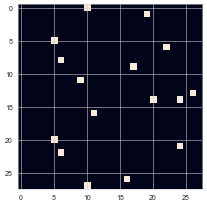

In [53]:
draw(grid)

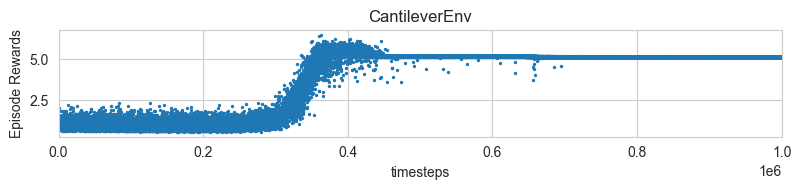

In [54]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [55]:
obs = env.reset()

In [56]:
obs = obs[0]

In [57]:
model_best = PPO.load(log_dir + "best_model.zip", env = env)

In [58]:
i=0
ans=[]
while i<1000:
    action, _states = model_best.predict(obs)
    obs, rewards, dones, _ , info = env.step(action)
    ans.append(obs)
    if dones:
        break
    
    i+=1

In [59]:
OBS=[ans[-1]['plane0'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane1'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane2'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane3'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane4'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane5'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane6'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane7'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane8'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane9'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane10'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane11'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane12'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane13'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane14'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane15'].astype(np.uint8).reshape(x0//4,y0//4)]


grid = construct(OBS)


Final Cantilever beam design:


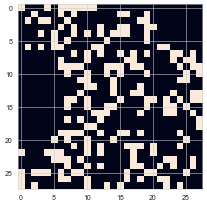

In [60]:
draw(grid)

In [61]:
args = get_args(*mbb_beam(rd=-1))
tmp, const = fast_stopt(args, grid.astype(float))

In [62]:
tmp

5055789.540406996

In [63]:
const

0.25892857142857145

In [64]:
grid

array([[1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 